### Table of Contents   
#### How has CWD changed in redwood forests throughout the inventory? Are there differences between p-ram and fire status or burn scar?
- **CWD Volume Modeling**       
    -[GLM for CWD Volume](#GLM-for-CWD-Volume)    
    -[GAM for CWD](#GAM-for-CWD)   
    -[Mixed Effect Model for CWD](#Mixed-Effect-Model-for-CWD)    
    -[Model Comparison](#Model-Comparison)   

- **Dead to live ratio modeling**    
    -[GLM for Dead to Live Ratio](#GLM-for-Dead-to-Live-Ratio)    
   


### Install Packages   

In [1]:
getwd()
setwd('sheets_calpoly')
getwd()
library('car')
library('mgcv')
library('lme4')
library('ggplot2')

[1] "C:/Users/benpa/Documents/juptyer/cal_poly"

[1] "C:/Users/benpa/Documents/juptyer/cal_poly/sheets_calpoly"

Warning message:
"package 'car' was built under R version 3.6.3"
Loading required package: carData

Warning message:
"package 'carData' was built under R version 3.6.3"
Loading required package: nlme

This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.

Warning message:
"package 'lme4' was built under R version 3.6.3"
Loading required package: Matrix

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 


Attaching package: 'lme4'


The following object is masked from 'package:nlme':

    lmList


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang



### Recycle Functions

In [42]:
#annova tests
run_anova1 = function(data, response, factor_var) {
  print('Running 1 way ANNOVA')
  data[[factor_var]] = as.factor(data[[factor_var]])
    y = data[[response]]
    x = data[[factor_var]]
    formula = as.formula(paste(response, "~", factor_var))
    # Extract the actual response and factor columns
  print(aggregate(y ~ x, data=data, mean))
    print(paste('group mean:', mean(y)))
    # Plot 
  print('Normality check')
    hist(y, main = paste("Histogram of", response), xlab = response, col = "lightblue", 
       border = "white")
  p = ggplot() + geom_boxplot(aes(x = x,y=y,fill=x))+
         labs(title = paste("Boxplot of", response, "by", factor_var),
                                    x = factor_var, 
                                    y = response)+
         theme_bw()+
        geom_jitter(aes(x=x, y=y), color='black', size=0.3)
    print(p)
  model <- aov(formula, data = data)
  cat("=== ANOVA Table ===\n")
  print(summary(model))
  cat("\n=== Tukey HSD Test ===\n")
  print(TukeyHSD(model))
  return(model)
}
run_anova2 <- function(data, response, factor1, factor2) {
  print('Running two-way ANOVA...')
    data[[factor1]] <- as.factor(data[[factor1]])
  data[[factor2]] <- as.factor(data[[factor2]])
  y <- data[[response]]
  x1 <- data[[factor1]]
  x2 <- data[[factor2]]
  cat("=== Group Means by", factor1, "===\n")
  gm1 <- aggregate(as.formula(paste(response, "~", factor1)), data = data, mean)
  print(gm1)
  cat("\n=== Group Means by", factor2, "===\n")
  gm2 <- aggregate(as.formula(paste(response, "~", factor2)), data = data, mean)
  print(gm2)
  cat(paste("\nOverall mean:", round(mean(y, na.rm = TRUE), 2), "\n"))
  cat("\n=== Histogram of Response ===\n")
  hist(y, main = paste("Histogram of", response),
       xlab = response, col = "lightblue", border = "white")
    p <- ggplot(data, aes(x = x1, y = y, fill = x2)) +
    geom_boxplot(alpha = 0.7, position = position_dodge(width = 0.8)) +
    labs(title = paste("Boxplot of", response, "by", factor1, "and", factor2),
         x = factor1, y = response, fill = factor2) +
    theme_bw()+
    geom_jitter(aes(x=x1, y=y, fill=x2), color='black', size=0.3)
  print(p)
  formula_anova <- as.formula(paste(response, "~", factor1, "*", factor2))
  model <- aov(formula_anova, data = data)
  cat("\n=== ANOVA Table ===\n")
  print(summary(model))
  cat("\n=== Tukey HSD for", factor1, "===\n")
  print(TukeyHSD(model, factor1))
  cat("\n=== Tukey HSD for", factor2, "===\n")
  print(TukeyHSD(model, factor2))
  return(model)
}
#need log transformed for skewed data
run_anova2log <- function(data, response, factor1, factor2) {
  print('Running two-way ANOVA...')
  data$x1 <- as.factor(data[[factor1]])
data$x2 <- as.factor(data[[factor2]])
data$y_log <- log1p(data[[response]])
  cat("=== Group Means no log transformation", factor1, "===\n")
  gm1 <- aggregate(as.formula(paste(response, "~", factor1)), data = data, mean)
  print(gm1)
  cat("\n=== Group Means by", factor2, "===\n")
  gm2 <- aggregate(as.formula(paste(response, "~", factor2)), data = data, mean)
  print(gm2)
  cat("\n=== Histogram of Response ===\n")
  hist(data$y_log, main = paste("Histogram of log1p -", response),
       xlab = response, col = "lightblue", border = "white")
    p <- ggplot(data, aes(x = x1, y = y_log, fill = x2)) +
    geom_boxplot(alpha = 0.7, position = position_dodge(width = 0.8)) +
    labs(title = paste("Boxplot of", response, "by", factor1, "and", factor2),
         x = factor1, y = response, fill = factor2) +
    theme_bw()+
    geom_jitter(aes(x=x1, y=y_log, fill=x2), color='black', size=0.3)
  print(p)
print('===checking for balance===')
print(table(data$x1, data$x2))
  formula_anova <- y_log ~ x1 * x2
  model <- aov(formula_anova, data = data)
  cat("\n=== ANOVA Table ===\n")
  print(summary(model))
  TukeyHSD(model, "x1")
  TukeyHSD(model, "x2")
  return(model)
}
# Interactions
interactions = function(data, response, x, hue){
    
  p = ggplot(data, aes_string(x = x, y = response, color = hue)) +
    geom_point() +
    geom_smooth(method = "lm", se = FALSE, aes_string(group = hue, color = hue))+
    theme_bw() +
    labs(title = paste("Interaction plot:", response, "vs", x, "by", hue))
  print(p)
}
#glm-gauss
run_glm_gauss = function(response, predictors, data){
    print('Generalized linear model using gaussian algorithm..')
    formula = as.formula(paste("log1p(", response, ") ~", predictors))
    model=glm(formula, data=data, family=gaussian)
    print('===GLM model summary ===')
    print(summary(model))
    print('====Adjusted sum of squares===')
    print(Anova(model, type=3))
    r2 <- 1 - (model$deviance / model$null.deviance)
    cat(paste('====R2:', r2))
    par(mfrow = c(1, 3))
    plot(model, which=1)
    plot(model, which=2)
    hist(residuals(model))
    return(model)
}


#### GLM for CWD Volume   
This only focuses on redwood forests. We know there are na's for data from 2006/7, so we will drap na's and only analyze post 2007.

,X,BS_plot,SampleYear,p_ram,group,elevation,slope,dead_live_ratio,SE.Class,stem_count,fire_presence,total.volume.per.plot..500m2.
2,1,BS002,2010,1,control,359,33,0.1875,SESE_D,3,0,0


[1] "Running two-way ANOVA..."
=== Group Means no log transformation fire_presence ===
  fire_presence total.volume.per.plot..500m2.
1             0                      6.009723
2             1                      4.860247

=== Group Means by p_ram ===
  p_ram total.volume.per.plot..500m2.
1     0                      5.480181
2     1                      5.103611

=== Histogram of Response ===


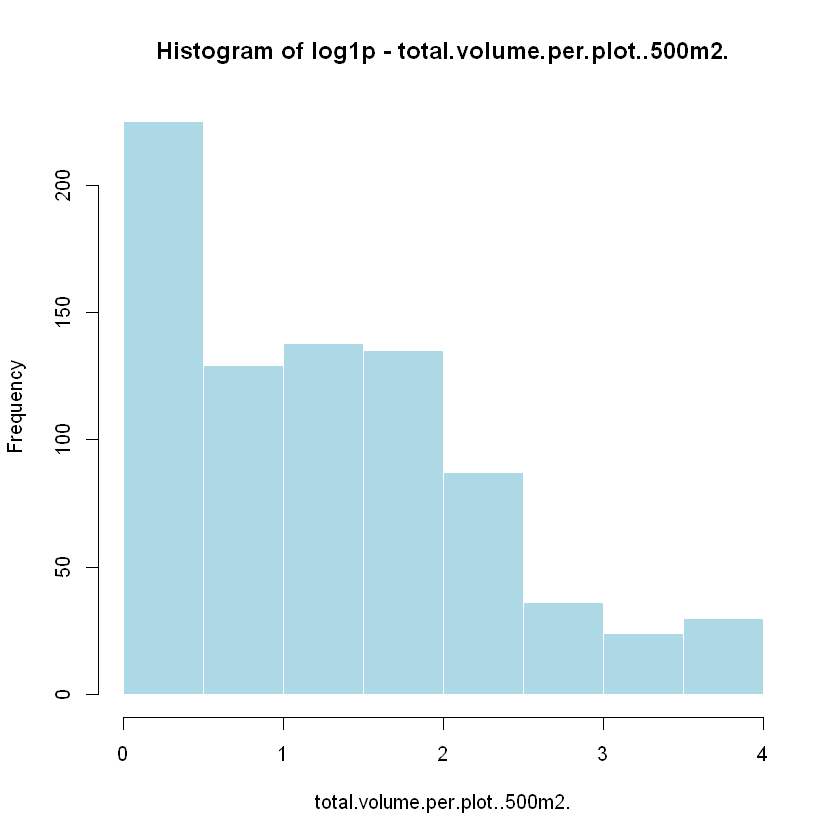

[1] "===checking for balance==="
   
      0   1
  0  21 219
  1 192 372

=== ANOVA Table ===
             Df Sum Sq Mean Sq F value Pr(>F)  
x1            1    2.9   2.902   2.951 0.0862 .
x2            1    3.3   3.279   3.334 0.0682 .
x1:x2         1    0.0   0.034   0.034 0.8531  
Residuals   800  786.7   0.983                 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Call:
   aov(formula = formula_anova, data = data)

Terms:
                      x1       x2    x1:x2 Residuals
Sum of Squares    2.9023   3.2791   0.0337  786.7480
Deg. of Freedom        1        1        1       800

Residual standard error: 0.9916829
Estimated effects may be unbalanced

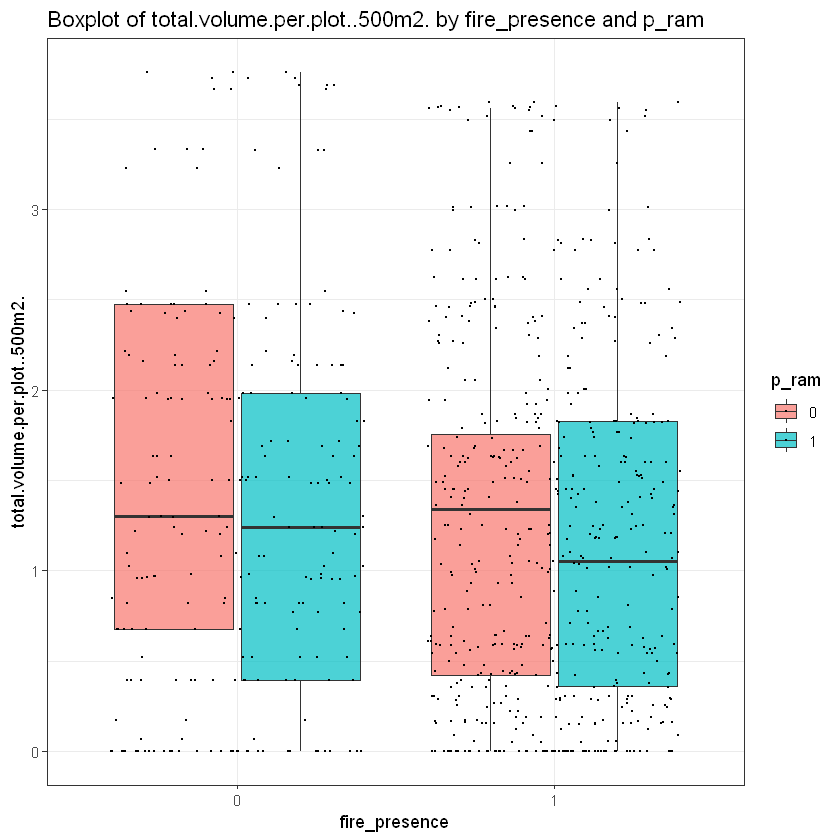

In [43]:
dfCWD = read.csv('cwd.csv')
dfCWD = na.omit(dfCWD)
head(dfCWD, n=1)
run_anova2log(dfCWD, 'total.volume.per.plot..500m2.', 'fire_presence', 'p_ram')

**Even with log transformation, we can see y is not normally distributed, unbalanced between fire presence and p ram groups. Very little control data. ANOVA alone may not be the test..**

[1] "==Looking for interactions..=="


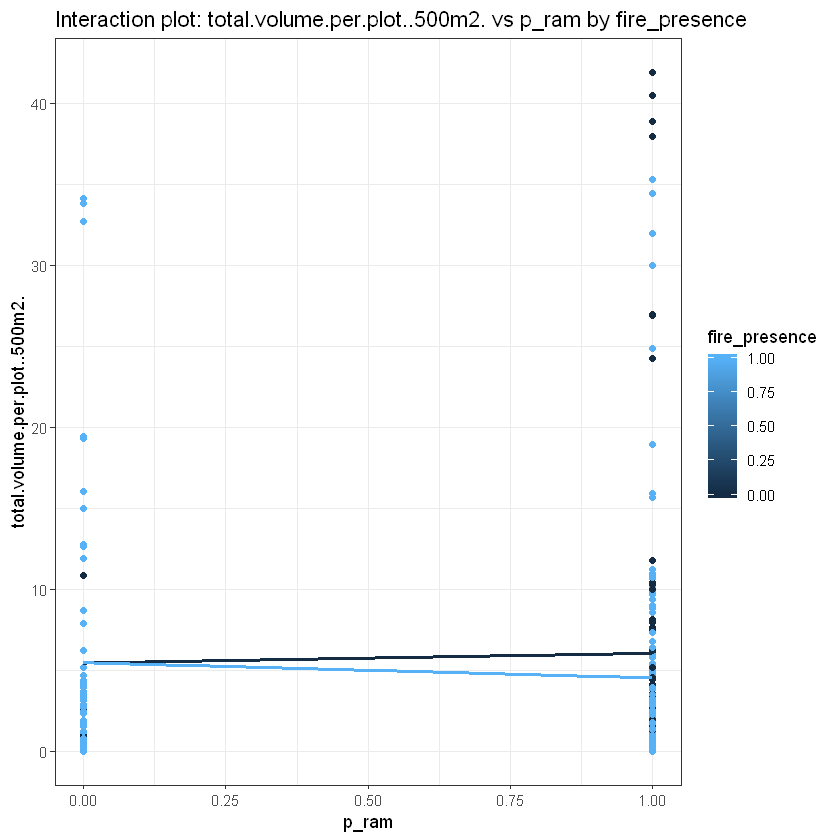

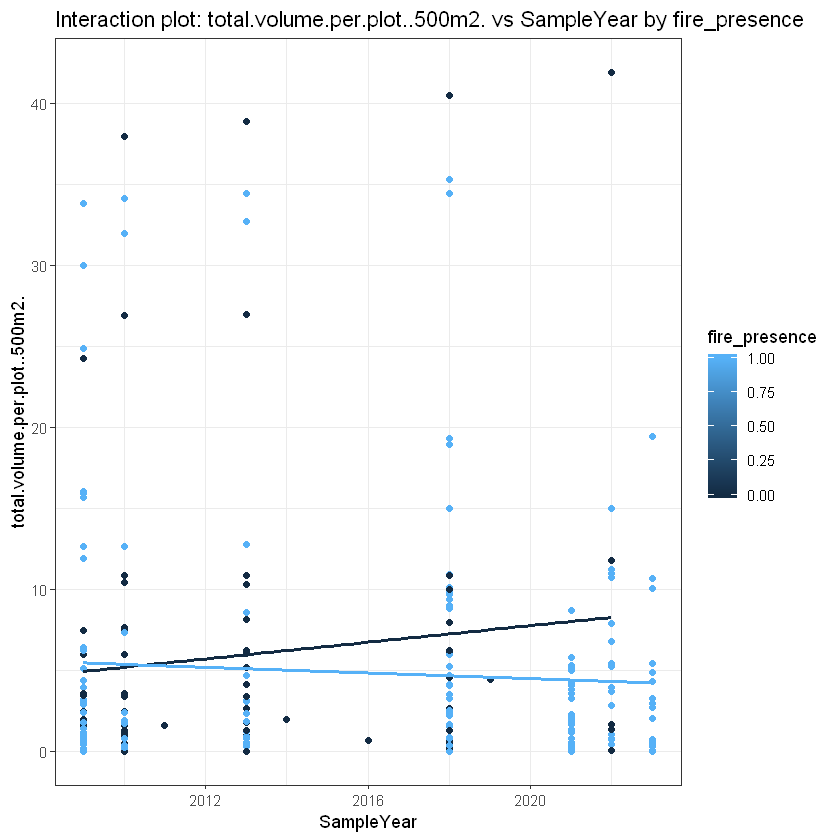

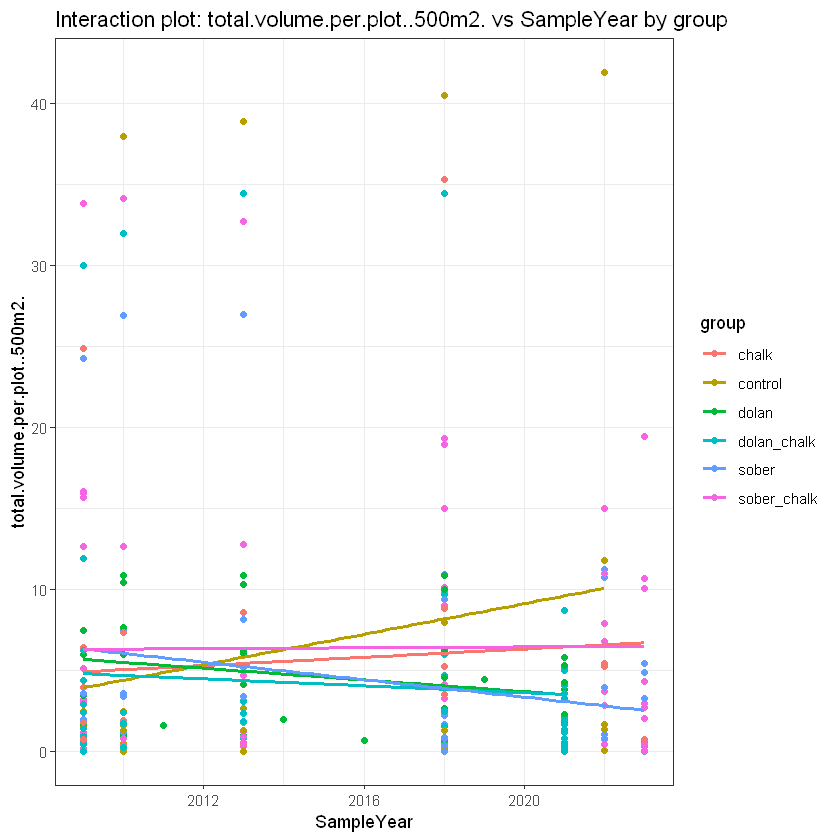

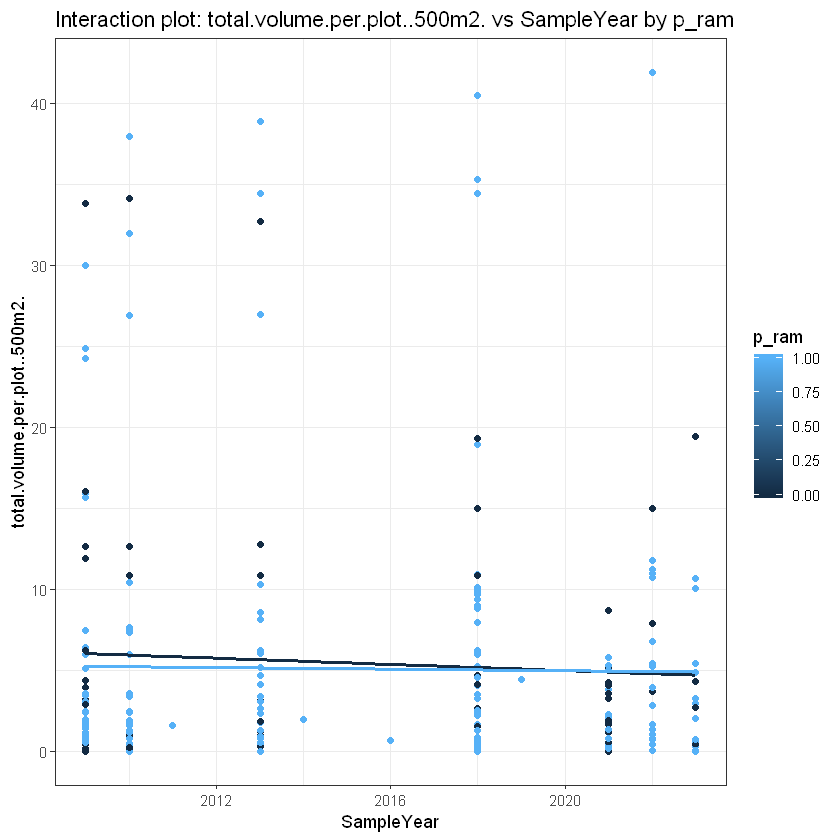

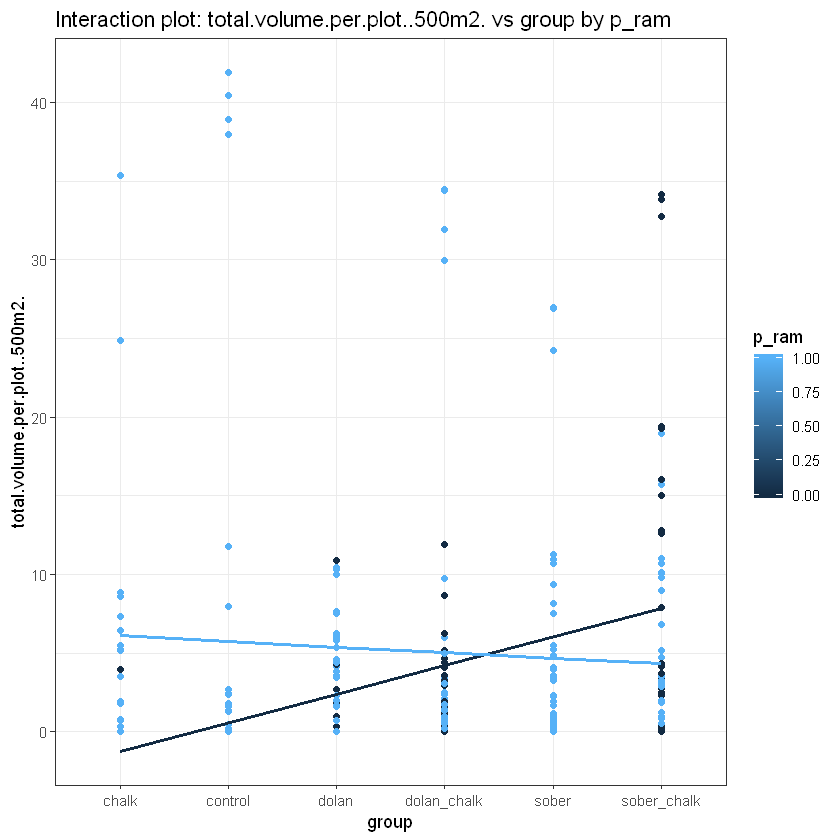

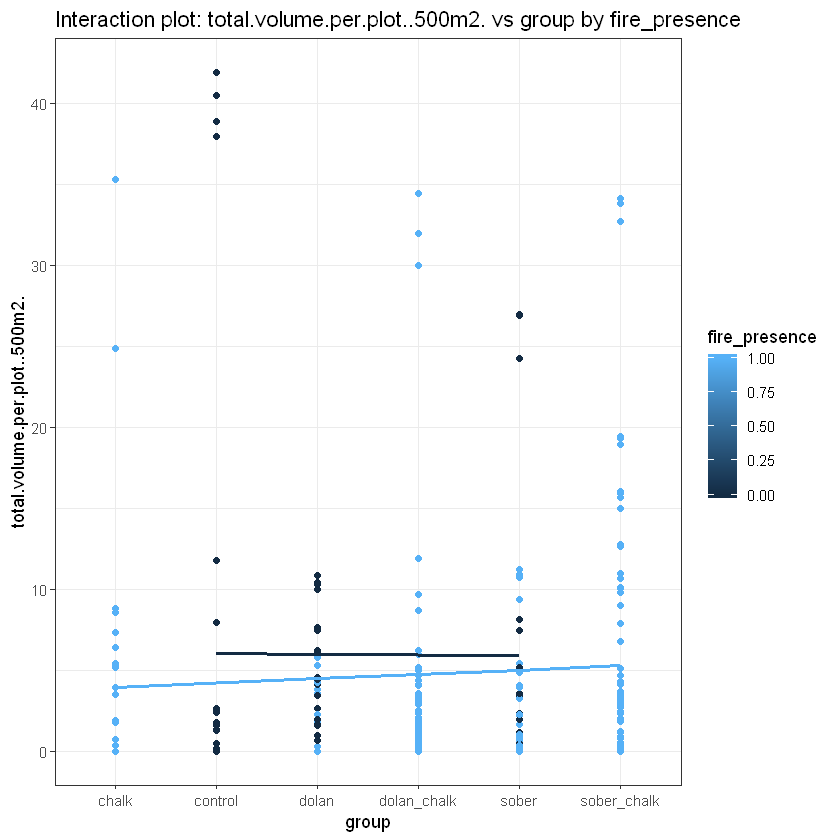

In [48]:
print('==Looking for interactions..==')
interactions(data=dfCWD, response="total.volume.per.plot..500m2.", x="p_ram", hue='fire_presence')
interactions(data=dfCWD, response="total.volume.per.plot..500m2.", x="SampleYear", hue='fire_presence')
interactions(data=dfCWD, response="total.volume.per.plot..500m2.", x="SampleYear", hue='group')
interactions(data=dfCWD, response="total.volume.per.plot..500m2.", x="SampleYear", hue='p_ram')
interactions(data=dfCWD, response="total.volume.per.plot..500m2.", x="group", hue='p_ram')
interactions(data=dfCWD, response="total.volume.per.plot..500m2.", x="group", hue='fire_presence')

[1] "Generalized linear model using gaussian algorithm.."
[1] "===GLM model summary ==="

Call:
glm(formula = formula, family = gaussian, data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-1.56033  -0.79276  -0.05896   0.58168   2.69030  

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)         -47.027115  15.224710  -3.089  0.00208 ** 
SampleYear            0.024314   0.007592   3.203  0.00142 ** 
p_ram                 0.094493   0.237253   0.398  0.69053    
fire_presence        -0.481698   0.267333  -1.802  0.07195 .  
groupcontrol         -0.965656   0.213555  -4.522 7.07e-06 ***
groupdolan           -0.381223   0.185595  -2.054  0.04030 *  
groupdolan_chalk     -0.326278   0.142312  -2.293  0.02213 *  
groupsober           -0.526176   0.159410  -3.301  0.00101 ** 
groupsober_chalk      0.003699   0.142147   0.026  0.97925    
p_ram:fire_presence  -0.200578   0.252588  -0.794  0.42738    
---
Signif. codes


Call:  glm(formula = formula, family = gaussian, data = data)

Coefficients:
        (Intercept)           SampleYear                p_ram  
         -47.027115             0.024314             0.094493  
      fire_presence         groupcontrol           groupdolan  
          -0.481698            -0.965656            -0.381223  
   groupdolan_chalk           groupsober     groupsober_chalk  
          -0.326278            -0.526176             0.003699  
p_ram:fire_presence  
          -0.200578  

Degrees of Freedom: 803 Total (i.e. Null);  794 Residual
Null Deviance:	    793 
Residual Deviance: 748.1 	AIC: 2246

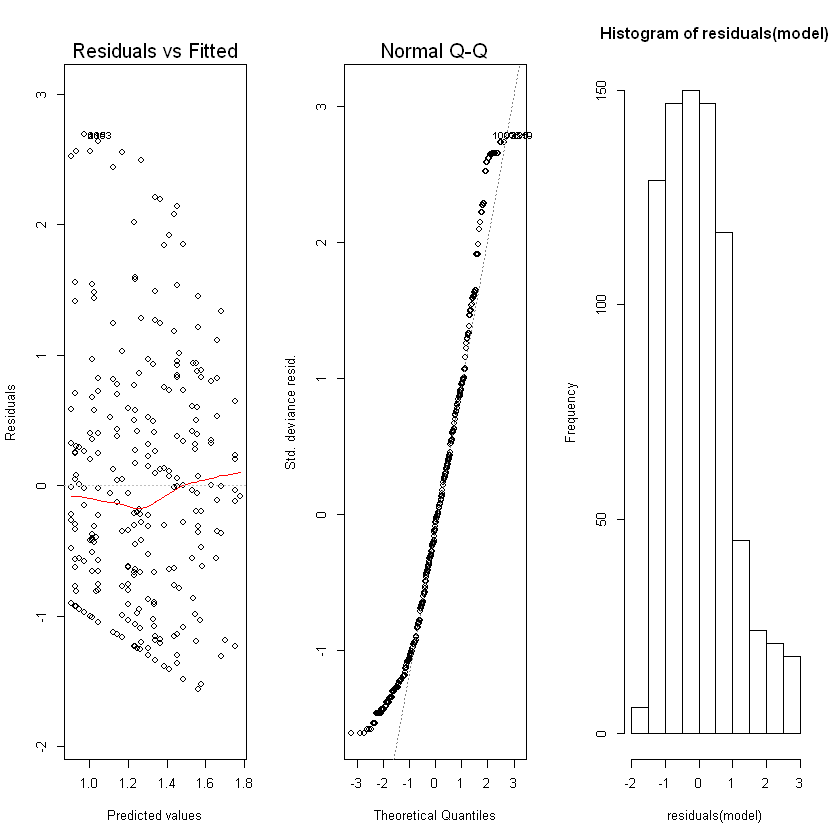

In [49]:
run_glm_gauss(
  response = "total.volume.per.plot..500m2.",
  predictors = "SampleYear + p_ram*fire_presence + group",
  data = dfCWD
)

**Heteroscedasticity??**

#### GAM for CWD


Family: gaussian 
Link function: identity 

Formula:
log1p(total.volume.per.plot..500m2.) ~ s(SampleYear) + s(slope) + 
    s(elevation) + p_ram + group + fire_presence

Parametric coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)       2.06720    0.20296  10.185  < 2e-16 ***
p_ram             0.16497    0.09415   1.752   0.0801 .  
groupcontrol     -1.10756    0.21063  -5.258 1.88e-07 ***
groupdolan       -0.23109    0.18541  -1.246   0.2130    
groupdolan_chalk -0.34808    0.14867  -2.341   0.0195 *  
groupsober       -0.72068    0.15956  -4.517 7.26e-06 ***
groupsober_chalk  0.05519    0.15405   0.358   0.7203    
fire_presence    -0.80248    0.12802  -6.269 6.03e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Approximate significance of smooth terms:
                edf Ref.df      F p-value    
s(SampleYear) 1.411  1.707  7.013 0.00123 ** 
s(slope)      8.921  8.997 18.340 < 2e-16 ***
s(elevation)  7.190  8.202 15.431 

[1] 2049.868

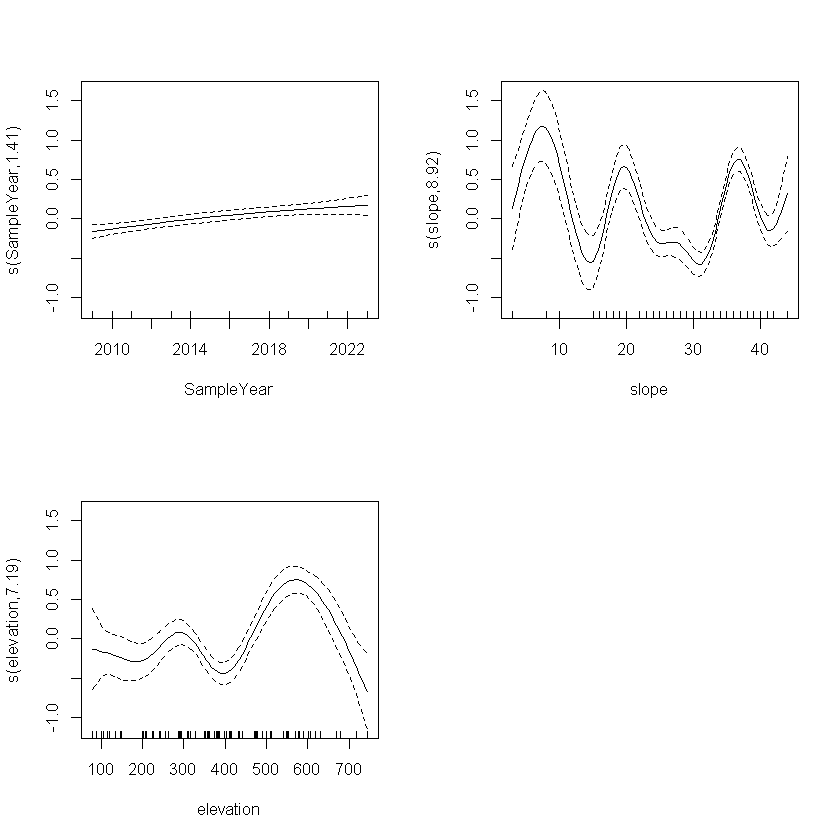


Method: GCV   Optimizer: magic
Smoothing parameter selection converged after 33 iterations.
The RMS GCV score gradient at convergence was 1.526552e-07 .
The Hessian was positive definite.
Model rank =  35 / 35 

Basis dimension (k) checking results. Low p-value (k-index<1) may
indicate that k is too low, especially if edf is close to k'.

                k'  edf k-index p-value    
s(SampleYear) 9.00 1.41    0.34  <2e-16 ***
s(slope)      9.00 8.92    0.19  <2e-16 ***
s(elevation)  9.00 7.19    0.18  <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



Family: gaussian 
Link function: identity 

Formula:
log1p(total.volume.per.plot..500m2.) ~ s(SampleYear) + s(slope) + 
    s(elevation) + p_ram + group + fire_presence

Parametric Terms:
              df     F  p-value
p_ram          1  3.07   0.0801
group          5 14.20 2.59e-13
fire_presence  1 39.30 6.03e-10

Approximate significance of smooth terms:
                edf Ref.df      F p-value
s(SampleYear) 1.411  1.707  7.013 0.00123
s(slope)      8.921  8.997 18.340 < 2e-16
s(elevation)  7.190  8.202 15.431 < 2e-16

[1] "r2: 0.266133299594478"


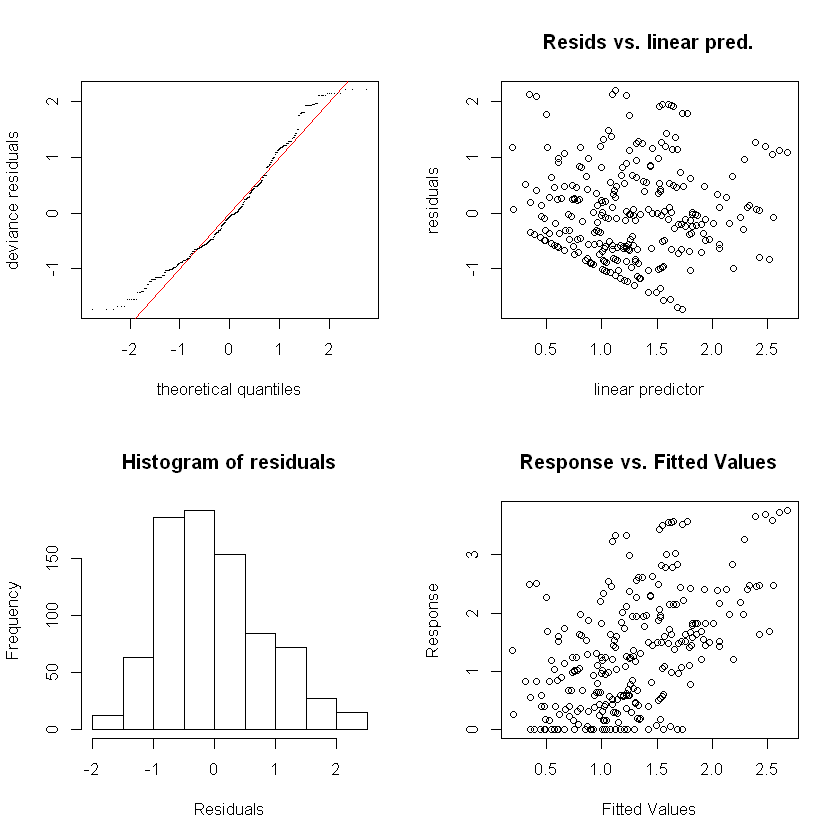

In [73]:
gam_model <- gam(
  log1p(total.volume.per.plot..500m2.) ~ 
    s(SampleYear) +       # smooth for year
    s(slope) +            # smooth for slope
    s(elevation) +        # smooth for elevation
    p_ram + group + fire_presence ,  
  data = dfCWD,
  family = gaussian()
)
summary(gam_model)   
plot(gam_model, pages=1)  
AIC(gam_model)
gam.check(gam_model) 
anova(gam_model)
r2 = summary(gam_model)$r.sq
print(paste("r2:", r2))

**P ram status not significant?** Not sure if model is designed correctly.

#### Mixed Effect Model for CWD

Linear mixed model fit by REML ['lmerMod']
Formula: log1p(total.volume.per.plot..500m2.) ~ SampleYear + p_ram + group +  
    fire_presence + slope + elevation + (1 | BS_plot)
   Data: dfCWD

REML criterion at convergence: 1477.2

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.0887 -0.4446 -0.0075  0.4373  3.2176 

Random effects:
 Groups   Name        Variance Std.Dev.
 BS_plot  (Intercept) 0.7498   0.8659  
 Residual             0.2540   0.5040  
Number of obs: 804, groups:  BS_plot, 83

Fixed effects:
                   Estimate Std. Error t value
(Intercept)      -6.427e+01  8.340e+00  -7.707
SampleYear        3.295e-02  4.153e-03   7.933
p_ram             1.078e-01  2.443e-01   0.441
groupcontrol     -9.931e-01  4.552e-01  -2.181
groupdolan       -4.303e-01  4.316e-01  -0.997
groupdolan_chalk -3.137e-01  4.131e-01  -0.759
groupsober       -7.066e-01  4.143e-01  -1.705
groupsober_chalk  7.945e-02  4.014e-01   0.198
fire_presence    -5.630e-01  8.447e-02  -6.665
slop

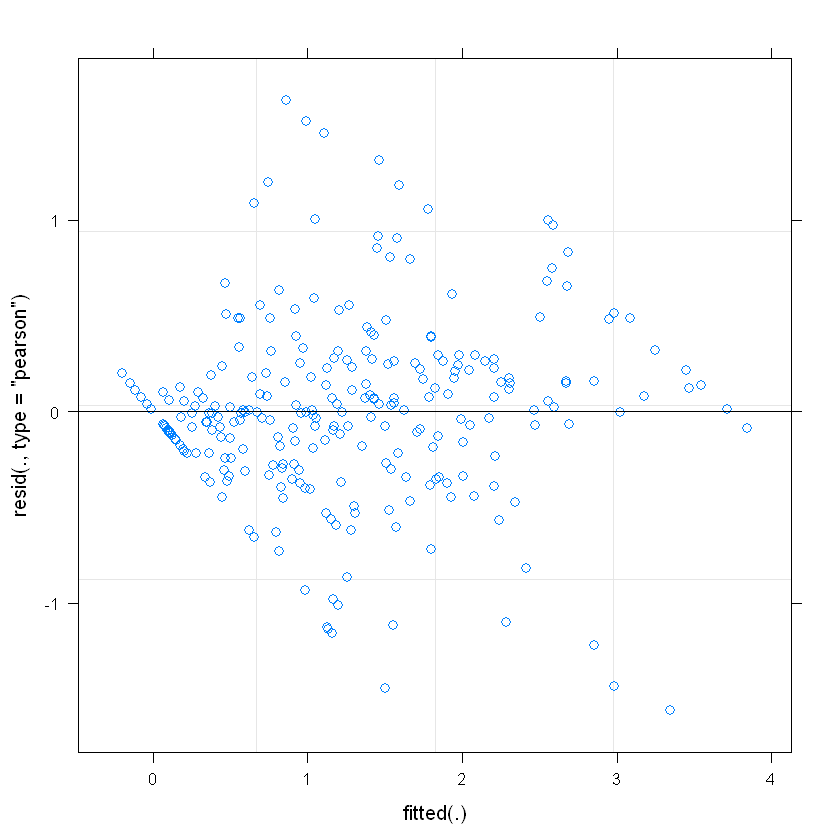

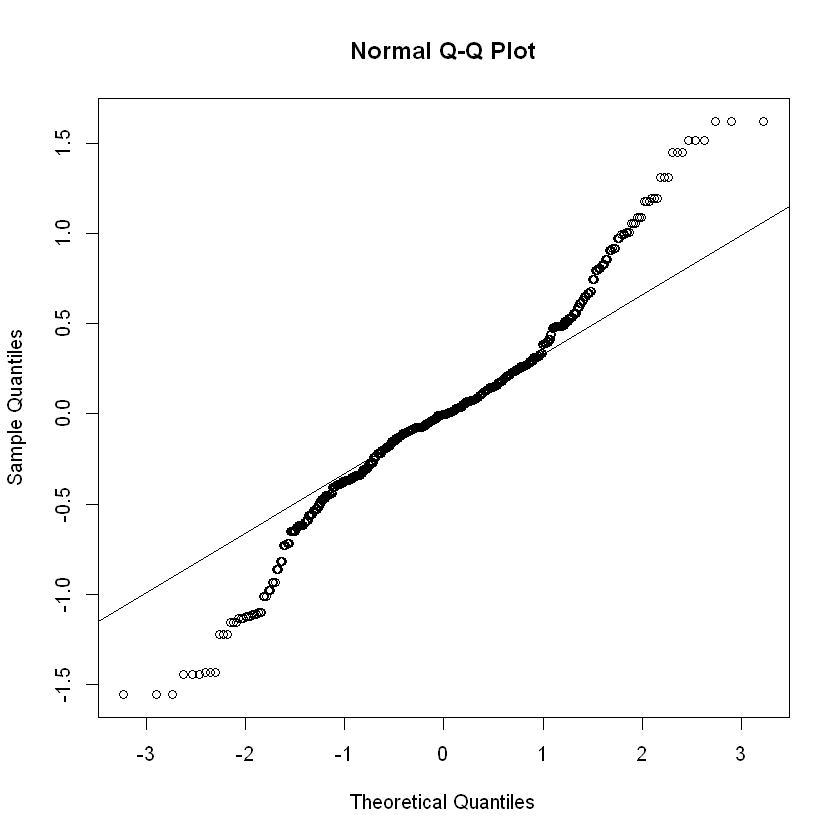

In [39]:
mixed_model <- lmer(
  log1p(total.volume.per.plot..500m2.) ~ SampleYear + p_ram + group + fire_presence + slope + elevation +
    (1 | BS_plot),
  data = dfCWD
)
summary(mixed_model)
plot(mixed_model)
qqnorm(residuals(mixed_model))
qqline(residuals(mixed_model))

#### Model Comparison   

In [40]:
AIC(glm_model, gam_model, mixed_model)

,df,AIC
glm_model,13.00000,2243.344
gam_model,26.52121,2049.868
mixed_model,13.00000,1503.219


#### GLM for Dead to Live Ratio

In [3]:
mort_rate = read.csv('mortality.csv')
summary(mort_rate)
head(mort_rate)

       X             BS_plot       SampleYear       p_ram      
 Min.   :   0.0   BS027  :  18   Min.   :2006   Min.   :0.000  
 1st Qu.: 667.8   BS052  :  18   1st Qu.:2007   1st Qu.:0.000  
 Median :1281.5   BS053  :  18   Median :2010   Median :1.000  
 Mean   :1262.7   BS058  :  18   Mean   :2012   Mean   :0.737  
 3rd Qu.:1876.2   BS124  :  18   3rd Qu.:2018   3rd Qu.:1.000  
 Max.   :2441.0   BS140  :  18   Max.   :2023   Max.   :1.000  
                  (Other):1044                                 
         group      fire_status    elevation       slope      
 chalk      : 96   Fire   :975   Min.   : 25   Min.   : 0.00  
 control    :177   No Fire:177   1st Qu.:291   1st Qu.:25.00  
 dolan      :159                 Median :382   Median :32.00  
 dolan_chalk:249                 Mean   :388   Mean   :30.05  
 sober      :198                 3rd Qu.:493   3rd Qu.:36.00  
 sober_chalk:273                 Max.   :744   Max.   :44.00  
                                               

X,BS_plot,SampleYear,p_ram,group,fire_status,elevation,slope,dead_live_ratio,SE.Class,stem_count,fire_presence
0,BS002,2006,1,control,No Fire,359,33,0.0625000,SESE_D,1,0
1,BS002,2010,1,control,No Fire,359,33,0.1875000,SESE_D,3,0
2,BS002,2013,1,control,No Fire,359,33,0.1111111,SESE_D,2,0
3,BS002,2018,1,control,No Fire,359,33,0.1764706,SESE_D,3,0
4,BS002,2022,1,control,No Fire,359,33,0.2307692,SESE_D,3,0
26,BS027,2006,1,control,No Fire,244,41,0.1818182,SESE_D,2,0


In [34]:
glm_model = glm(log1p(dead_live_ratio) ~ SampleYear * p_ram + SampleYear * group + SampleYear * fire_presence, 
                data=mort_rate, family=gaussian)
summary(glm_model)
Anova(glm_model, type=3)
r2 <- 1 - (glm_model$deviance / glm_model$null.deviance)
r2


Call:
glm(formula = log1p(dead_live_ratio) ~ SampleYear * p_ram + SampleYear * 
    group + SampleYear * fire_presence, family = gaussian, data = mort_rate)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-0.94729  -0.17282  -0.01561   0.14966   1.98821  

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                  1.457e+02  1.924e+01   7.572 7.60e-14 ***
SampleYear                  -7.254e-02  9.571e-03  -7.579 7.19e-14 ***
p_ram                       -1.297e+01  8.826e+00  -1.469  0.14206    
groupcontrol                -1.236e+02  1.963e+01  -6.298 4.30e-10 ***
groupdolan                  -1.755e+02  1.658e+01 -10.585  < 2e-16 ***
groupdolan_chalk            -1.163e+02  1.532e+01  -7.590 6.66e-14 ***
groupsober                  -1.491e+01  1.506e+01  -0.990  0.32253    
groupsober_chalk            -3.188e+01  1.490e+01  -2.139  0.03261 *  
fire_presence               -3.976e+01  1.261e+01  -3.154  0.001

,LR Chisq,Df,Pr(>Chisq)
SampleYear,57.446464,1,3.473051e-14
p_ram,2.158534,1,1.417799e-01
group,237.091653,5,3.227592e-49
fire_presence,9.947101,1,1.611029e-03
SampleYear:p_ram,2.197554,1,1.382299e-01
SampleYear:group,238.407213,5,1.685710e-49
SampleYear:fire_presence,10.282003,1,1.343340e-03


[1] 0.4660358

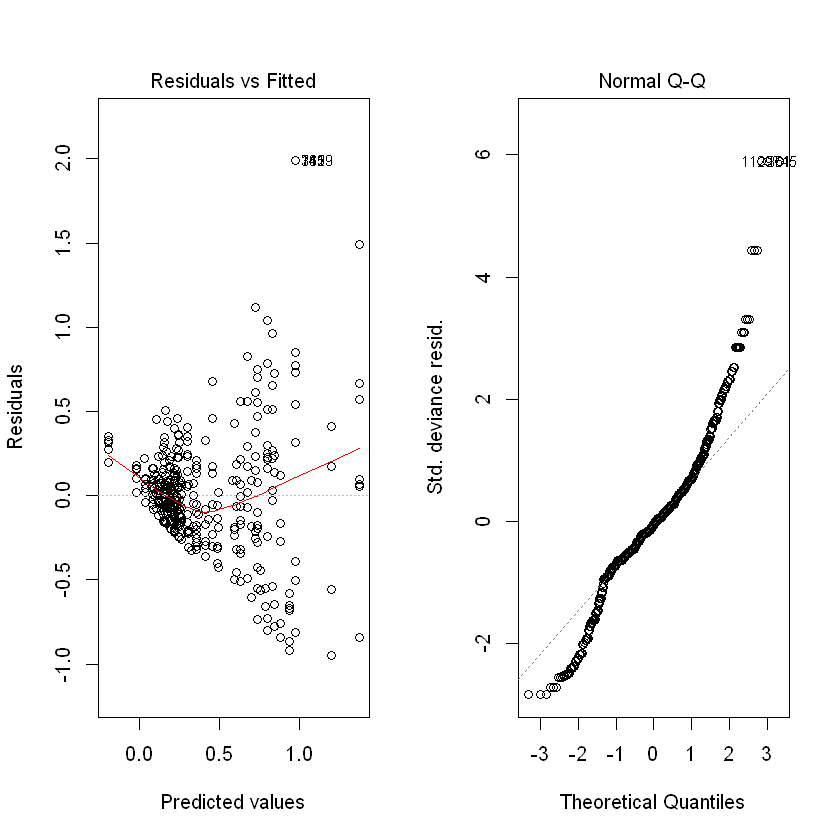

In [35]:
par(mfrow = c(1, 2))
plot(glm_model, which=1)
plot(glm_model, which=2)
par(mfrow = c(1, 1))